In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d computingvictor/transactions-fraud-datasets
!unzip -q transactions-fraud-datasets.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets
License(s): apache-2.0
 92% 321M/348M [00:00<00:00, 662MB/s]
100% 348M/348M [00:00<00:00, 612MB/s]


In [2]:
import os
import json
import csv
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import h5py
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, to_date, when, trim
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc

plt.style.use('default')
sns.set_palette("husl")

In [3]:
os.makedirs("/content/working", exist_ok=True)

In [4]:
with open('/content/mcc_codes.json', 'r') as json_file:
    json_data = json.load(json_file)
data_list = [{"mcc_code": key, "description": value} for key, value in json_data.items()]
with open('/content/working/mcc_codes.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['mcc_code', 'description'])
    writer.writeheader()
    writer.writerows(data_list)

with open('/content/train_fraud_labels.json', 'r') as json_file:
    json_data = json.load(json_file)
target_data = json_data['target']
data_list = [{"transaction_id": key, "fraud_label": value} for key, value in target_data.items()]
with open('/content/working/train_fraud_labels.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['transaction_id', 'fraud_label'])
    writer.writeheader()
    writer.writerows(data_list)

In [5]:
df_transactions = pl.read_csv("/content/transactions_data.csv")
df_fraud_labels = pl.read_csv("/content/working/train_fraud_labels.csv")
df_filtered_transactions = df_transactions.join(
    df_fraud_labels,
    left_on="id",
    right_on="transaction_id",
    how="inner"
)
df_cards = pl.read_csv("/content/cards_data.csv")
df_combined = df_filtered_transactions.join(
    df_cards,
    left_on="card_id",
    right_on="id",
    how="left"
)
card_brand_counts = df_combined.group_by("card_brand").count()
print(card_brand_counts)

# output_df = df_combined.select([
#     "id", "date", "client_id", "card_id", "amount",
#     "merchant_id", "card_brand", "fraud_label", "mcc"
# ])
output_df = df_combined.filter(pl.col("card_brand") == "Amex").select([
    "id", "date", "client_id", "card_id", "amount",
    "merchant_id", "card_brand", "fraud_label", "mcc"
])
output_path = "/content/working/filtered_transactions.csv"
output_df.write_csv(output_path)
print(f"Đã lưu {output_df.height} giao dịch vào '{output_path}'")


/tmp/ipython-input-5-1670585272.py:16: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  card_brand_counts = df_combined.group_by("card_brand").count()


shape: (4, 2)
┌────────────┬─────────┐
│ card_brand ┆ count   │
│ ---        ┆ ---     │
│ str        ┆ u32     │
╞════════════╪═════════╡
│ Visa       ┆ 3321615 │
│ Amex       ┆ 572424  │
│ Mastercard ┆ 4795682 │
│ Discover   ┆ 225242  │
└────────────┴─────────┘
Đã lưu 572424 giao dịch vào '/content/working/filtered_transactions.csv'


In [6]:
spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()
df_cards = spark.read.csv("/content/cards_data.csv", header=True, inferSchema=True)
df_users = spark.read.csv("/content/users_data.csv", header=True, inferSchema=True)
df_filtered_transactions = spark.read.csv(output_path, header=True, inferSchema=True)

# Làm sạch cards
df_cards = df_cards.drop("card_on_dark_web")
df_cards = df_cards.withColumn("credit_limit", regexp_replace(col("credit_limit"), "[\$,]", "").cast(FloatType()))
df_cards = df_cards.withColumn("acct_open_date", to_date(col("acct_open_date"), "MM/yyyy"))
df_cards = df_cards.withColumn("PIN_Change_Due", when(col("year_pin_last_changed") < 2025 - 7, "Yes").otherwise("No"))

# Làm sạch users
df_users = df_users.withColumn("per_capita_income", regexp_replace(col("per_capita_income"), "[\$,]", "").cast(FloatType()))
df_users = df_users.withColumn("yearly_income", regexp_replace(col("yearly_income"), "[\$,]", "").cast(FloatType()))
df_users = df_users.withColumn("total_debt", regexp_replace(col("total_debt"), "[\$,]", "").cast(FloatType()))
df_users = df_users.withColumn("retirement_status", when(col("current_age") >= col("retirement_age"), "Retired").otherwise("Not Retired"))
df_users = df_users.withColumn("age_group",
    when(col("current_age") <= 30, "18-30")
    .when(col("current_age") <= 45, "31-45")
    .when(col("current_age") <= 60, "46-60")
    .otherwise("60+")
)
df_users = df_users.withColumn("Debt_to_Income_Ratio", col("total_debt") / col("yearly_income"))

# Làm sạch giao dịch
df_filtered_transactions = df_filtered_transactions.withColumn("amount", regexp_replace(col("amount"), "[\$,]", "").cast(FloatType()))


In [7]:
print("\nXem trước dữ liệu:")
print("Cards:")
df_cards.show(5, truncate=False)
print("Users:")
df_users.show(5, truncate=False)
print("Giao dịch lọc:")
df_filtered_transactions.show(5, truncate=False)


Xem trước dữ liệu:
Cards:
+----+---------+----------+---------------+----------------+-------+---+--------+----------------+------------+--------------+---------------------+--------------+
|id  |client_id|card_brand|card_type      |card_number     |expires|cvv|has_chip|num_cards_issued|credit_limit|acct_open_date|year_pin_last_changed|PIN_Change_Due|
+----+---------+----------+---------------+----------------+-------+---+--------+----------------+------------+--------------+---------------------+--------------+
|4524|825      |Visa      |Debit          |4344676511950444|12/2022|623|YES     |2               |24295.0     |2002-09-01    |2008                 |Yes           |
|2731|825      |Visa      |Debit          |4956965974959986|12/2020|393|YES     |2               |21968.0     |2014-04-01    |2014                 |Yes           |
|3701|825      |Visa      |Debit          |4582313478255491|02/2024|719|YES     |2               |46414.0     |2003-07-01    |2004                 |Yes  

In [8]:
print("\nSố dòng:")
print(f"- Cards: {df_cards.count()}")
print(f"- Users: {df_users.count()}")
print(f"- Filtered Transactions: {df_filtered_transactions.count()}")


Số dòng:
- Cards: 6146
- Users: 2000
- Filtered Transactions: 572424


In [9]:
from pyspark.sql.functions import trim


In [10]:
df_temp = df_filtered_transactions.join(
    df_cards, df_filtered_transactions["card_id"] == df_cards["id"], "left"
).select(
    df_filtered_transactions["id"].alias("transaction_id"),
    df_filtered_transactions["client_id"],
    df_filtered_transactions["amount"],
    df_filtered_transactions["fraud_label"],
    df_filtered_transactions["mcc"],
    df_cards["credit_limit"]
)

df_combined = df_temp.join(
    df_users, df_temp["client_id"] == df_users["id"], "left"
).select(
    df_temp["transaction_id"],
    df_temp["client_id"],
    df_temp["amount"],
    df_temp["fraud_label"],
    df_temp["mcc"],
    df_temp["credit_limit"],
    df_users["gender"],
    df_users["retirement_status"],
    df_users["current_age"],
    df_users["per_capita_income"],
    df_users["yearly_income"],
    df_users["total_debt"],
    df_users["Debt_to_Income_Ratio"]
)

df_combined = df_combined.filter(trim(col("fraud_label")).isin(["Yes", "No"]))

label_counts = df_combined.groupBy("fraud_label").count()
total = df_combined.count()

label_weights = label_counts.withColumn(
    "weight", (total / col("count")).cast("float")
)

df_combined = df_combined.join(label_weights, "fraud_label", "left")

print("Đã kết hợp dữ liệu và tính trọng số (weight) để cân bằng label:")
df_combined.groupBy("fraud_label", "weight").count().show()


Đã kết hợp dữ liệu và tính trọng số (weight) để cân bằng label:
+-----------+---------+------+
|fraud_label|   weight| count|
+-----------+---------+------+
|         No|1.0016168|571500|
|        Yes| 619.5065|   924|
+-----------+---------+------+



# Logistic Regression - Tối ưu cho Fraud Detection

In [11]:
# Chuẩn bị features và pipeline
categorical_cols = ["mcc", "gender", "retirement_status"]
numerical_cols = [
    "amount", "current_age", "per_capita_income", "yearly_income",
    "total_debt", "Debt_to_Income_Ratio", "credit_limit"
]

indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in categorical_cols]
label_indexer = StringIndexer(inputCol="fraud_label", outputCol="label", handleInvalid="skip")
assembler = VectorAssembler(inputCols=[col + "_index" for col in categorical_cols] + numerical_cols,
                            outputCol="raw_features", handleInvalid="keep")
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)

# Tối ưu LR cho bài toán lệch nhãn
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    weightCol="weight",
    maxIter=200,
    regParam=0.001,
    elasticNetParam=0.5,
    threshold=0.3,
    standardization=True,
    fitIntercept=True
)

pipeline = Pipeline(stages=indexers + [label_indexer, assembler, scaler, lr])

In [19]:
# Training và evaluation
train_data, test_data = df_combined.randomSplit([0.8, 0.2], seed=42)

print(" Phân bố nhãn trong tập train:")
train_data.groupBy("fraud_label").count().show()

model = pipeline.fit(train_data)
predictions = model.transform(test_data)

# Đánh giá mô hình
auc_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
pr_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderPR")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

auc = auc_evaluator.evaluate(predictions)
pr_auc = pr_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)

print(" Kết quả đánh giá mô hình:")
print(f"AUC-ROC: {auc:.4f}")
print(f"AUC-PR: {pr_auc:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

 Phân bố nhãn trong tập train:
+-----------+------+
|fraud_label| count|
+-----------+------+
|         No|457160|
|        Yes|   749|
+-----------+------+

 Kết quả đánh giá mô hình:
AUC-ROC: 0.7398
AUC-PR: 0.0072
F1-Score: 0.4065
Precision: 0.9980
Recall: 0.2566


In [20]:
# Tối ưu threshold và tính metrics chi tiết
prob_predictions = predictions.select("label", "probability").rdd.map(
    lambda row: (float(row['label']), float(row['probability'][1]))
).collect()

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_threshold = 0.5
best_f1 = 0

print("Tối ưu threshold:")
print("Threshold | Precision | Recall | F1-Score")
print("-" * 40)

for threshold in thresholds:
    tp = fp = tn = fn = 0

    for true_label, prob in prob_predictions:
        pred = 1 if prob >= threshold else 0

        if true_label == 1 and pred == 1: tp += 1
        elif true_label == 0 and pred == 1: fp += 1
        elif true_label == 0 and pred == 0: tn += 1
        elif true_label == 1 and pred == 0: fn += 1

    precision_thresh = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_thresh = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision_thresh * recall_thresh) / (precision_thresh + recall_thresh) if (precision_thresh + recall_thresh) > 0 else 0

    print(f"{threshold:8.1f} | {precision_thresh:8.3f} | {recall_thresh:7.3f} | {f1_score:8.3f}")

    if f1_score > best_f1:
        best_f1 = f1_score
        best_threshold = threshold

print(f"\nBest threshold: {best_threshold} (F1-Score: {best_f1:.4f})")

# Tính fraud-specific metrics với best threshold
tp = fp = tn = fn = 0
for true_label, prob in prob_predictions:
    pred = 1 if prob >= best_threshold else 0
    if true_label == 1 and pred == 1: tp += 1
    elif true_label == 0 and pred == 1: fp += 1
    elif true_label == 0 and pred == 0: tn += 1
    elif true_label == 1 and pred == 0: fn += 1

fraud_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
fraud_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
fraud_f1 = 2 * (fraud_precision * fraud_recall) / (fraud_precision + fraud_recall) if (fraud_precision + fraud_recall) > 0 else 0
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

print(f"\nFraud Detection Metrics:")
print(f"Fraud Precision: {fraud_precision:.4f}")
print(f"Fraud Recall: {fraud_recall:.4f}")
print(f"Fraud F1-Score: {fraud_f1:.4f}")
print(f"False Positive Rate: {false_positive_rate:.4f}")

Tối ưu threshold:
Threshold | Precision | Recall | F1-Score
----------------------------------------
     0.1 |    0.002 |   1.000 |    0.003
     0.2 |    0.002 |   1.000 |    0.003
     0.3 |    0.002 |   0.920 |    0.004
     0.4 |    0.003 |   0.714 |    0.006
     0.5 |    0.004 |   0.560 |    0.009
     0.6 |    0.006 |   0.411 |    0.012
     0.7 |    0.009 |   0.349 |    0.017
     0.8 |    0.011 |   0.286 |    0.022
     0.9 |    0.015 |   0.166 |    0.027

Best threshold: 0.9 (F1-Score: 0.0267)

Fraud Detection Metrics:
Fraud Precision: 0.0145
Fraud Recall: 0.1657
Fraud F1-Score: 0.0267
False Positive Rate: 0.0172


In [21]:
# Feature importance analysis
lr_model = model.stages[-1]
feature_names = [col + "_index" for col in categorical_cols] + numerical_cols
coefficients = lr_model.coefficients.toArray()
feature_importance = [(abs(coef), name) for coef, name in zip(coefficients, feature_names)]
feature_importance.sort(reverse=True)

print("Top 10 Features quan trọng nhất:")
for i, (importance, feature) in enumerate(feature_importance[:10]):
    print(f"{i+1:2d}. {feature:20s}: {importance:.4f}")

Top 10 Features quan trọng nhất:
 1. per_capita_income   : 0.7543
 2. yearly_income       : 0.6806
 3. mcc_index           : 0.6132
 4. retirement_status_index: 0.4395
 5. Debt_to_Income_Ratio: 0.2079
 6. amount              : 0.1602
 7. gender_index        : 0.0736
 8. credit_limit        : 0.0032
 9. total_debt          : 0.0000
10. current_age         : 0.0000


## Model Evaluation & Visualization

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal     0.9995    0.2556    0.4071    114340
       Fraud     0.0019    0.9200    0.0038       175

    accuracy                         0.2566    114515
   macro avg     0.5007    0.5878    0.2054    114515
weighted avg     0.9980    0.2566    0.4065    114515



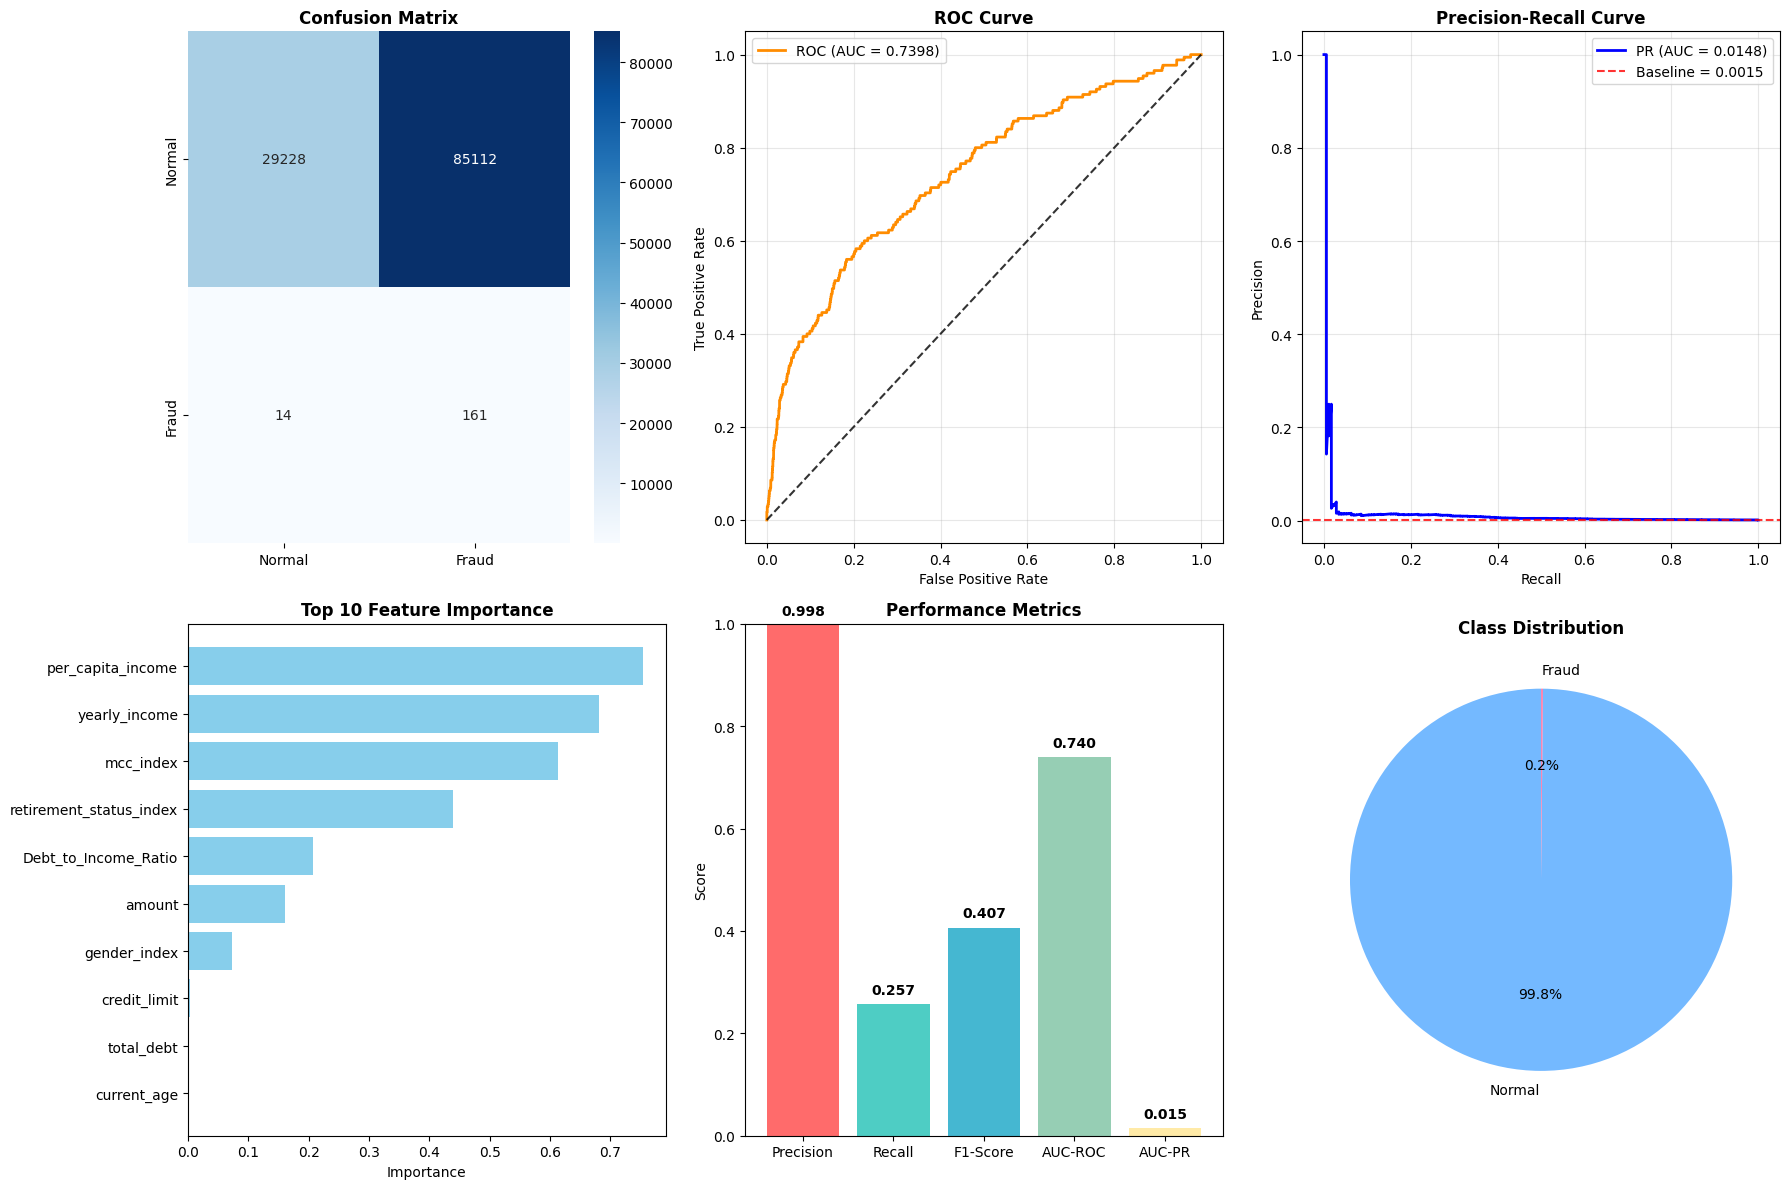

Visualization Complete - Collected 114515 predictions


In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc

# Thu thập dữ liệu cho visualization
pred_data = predictions.select("label", "prediction", "probability").collect()
y_true = [int(row['label']) for row in pred_data]
y_pred = [int(row['prediction']) for row in pred_data]
y_proba = [float(row['probability'][1]) for row in pred_data]

# Classification Report
print("CLASSIFICATION REPORT")
print("=" * 60)
class_report = classification_report(y_true, y_pred, target_names=['Normal', 'Fraud'], digits=4)
print(class_report)

# Confusion Matrix & ROC/PR Curves
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'], ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontweight='bold')

# 2. ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_true, y_proba)
auc_score = auc(fpr, tpr) # Renamed variable to avoid conflict
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc_score:.4f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.8)
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Precision-Recall Curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_proba)
auc_pr_curve = auc(recall_curve, precision_curve) # Renamed variable to avoid conflict
fraud_ratio = sum(y_true) / len(y_true)
axes[0,2].plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR (AUC = {auc_pr_curve:.4f})')
axes[0,2].axhline(y=fraud_ratio, color='red', linestyle='--', alpha=0.8, label=f'Baseline = {fraud_ratio:.4f}')
axes[0,2].set_xlabel('Recall')
axes[0,2].set_ylabel('Precision')
axes[0,2].set_title('Precision-Recall Curve', fontweight='bold')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Feature Importance
top_features = [item[1] for item in feature_importance[:10]]
top_importances = [item[0] for item in feature_importance[:10]]
axes[1,0].barh(range(len(top_features)), top_importances, color='skyblue')
axes[1,0].set_yticks(range(len(top_features)))
axes[1,0].set_yticklabels(top_features)
axes[1,0].set_xlabel('Importance')
axes[1,0].set_title('Top 10 Feature Importance', fontweight='bold')
axes[1,0].invert_yaxis()

# 5. Metrics Comparison
metrics_names = ['Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'AUC-PR']
metrics_values = [precision, recall, f1, auc_score, auc_pr_curve] # Used renamed variables
axes[1,1].bar(metrics_names, metrics_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[1,1].set_title('Performance Metrics', fontweight='bold')
axes[1,1].set_ylabel('Score')
axes[1,1].set_ylim([0, 1])
for i, v in enumerate(metrics_values):
    axes[1,1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# 6. Class Distribution
class_counts = [y_true.count(0), y_true.count(1)]
axes[1,2].pie(class_counts, labels=['Normal', 'Fraud'], colors=['#74B9FF', '#FD79A8'],
              autopct='%1.1f%%', startangle=90)
axes[1,2].set_title('Class Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Visualization Complete - Collected {len(y_true)} predictions")

## Model Saving & Summary

In [ ]:
import h5py # Explicitly import h5py here
import pickle # Explicitly import pickle here

# Lưu mô hình và tạo summary
model_path = "/content/working/best_fraud_detection_model"
h5_path = "/content/working/fraud_model_info.h5"
metadata_path = "/content/working/model_metadata.pkl"

# 1. Lưu Spark model
# Note: Spark ML models are saved in a directory structure, not a single file.
# The write().overwrite().save() method already handles this.
try:
    model.write().overwrite().save(model_path)
    print(f"Spark Model saved to: {model_path}")
except Exception as e:
    print(f"Error saving Spark model: {e}")

# 2. Lưu thông tin quan trọng vào .h5
try:
    with h5py.File(h5_path, 'w') as h5f:
        # Check if lr_model has intercept and coefficients before saving
        if hasattr(lr_model, 'intercept'):
            h5f.create_dataset('intercept', data=lr_model.intercept)
        if hasattr(lr_model, 'coefficients'):
            h5f.create_dataset('coefficients', data=lr_model.coefficients.toArray())

        h5f.create_dataset('best_threshold', data=best_threshold)
        h5f.create_dataset('best_f1_score', data=best_f1)

        # Feature info - encode strings to bytes
        h5f.create_dataset('feature_names', data=[name.encode('utf-8') for name in feature_names])
        h5f.create_dataset('categorical_cols', data=[col.encode('utf-8') for col in categorical_cols])
        h5f.create_dataset('numerical_cols', data=[col.encode('utf-8') for col in numerical_cols])

        # Metrics
        metrics = {
            'auc_roc': auc_score, 'auc_pr': auc_pr_curve, 'f1_score': f1, 'precision': precision, 'recall': recall,
            'fraud_precision': fraud_precision, 'fraud_recall': fraud_recall, 'fraud_f1': fraud_f1,
            'false_positive_rate': false_positive_rate
        }
        for metric_name, metric_value in metrics.items():
            h5f.create_dataset(f'metrics/{metric_name}', data=metric_value)
    print(f"H5 Model Info saved to: {h5_path}")
except Exception as e:
    print(f"Error saving H5 model info: {e}")


# 3. Lưu metadata
try:
    metadata = {
        'model_type': 'LogisticRegression',
        'training_samples': train_data.count(),
        'test_samples': test_data.count(),
        'best_threshold': best_threshold,
        'best_f1_score': best_f1,
        'performance_metrics': metrics,
        'feature_names': feature_names,
        'categorical_cols': categorical_cols,
        'numerical_cols': numerical_cols
    }
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    print(f"Metadata saved to: {metadata_path}")
except Exception as e:
    print(f"Error saving metadata: {e}")


# Summary Report
print("\nMODEL SUMMARY REPORT")
print("=" * 50)
print(f"Model Type: Logistic Regression")
print(f"Training Samples: {train_data.count():,}")
print(f"Test Samples: {test_data.count():,}")
print(f"Best Threshold: {best_threshold}")
print(f"Best F1-Score: {best_f1:.4f}")
print("\n Performance Metrics:")
print(f"   • AUC-ROC: {auc_score:.4f}")
print(f"   • AUC-PR: {auc_pr_curve:.4f}")
print(f"   • Fraud Precision: {fraud_precision:.4f}")
print(f"   • Fraud Recall: {fraud_recall:.4f}")
print(f"   • False Positive Rate: {false_positive_rate:.4f}")
print(f"\n Files Saved:")
print(f"   • Spark Model: {model_path}")
print(f"   • H5 Model Info: {h5_path}")
print(f"   • Metadata: {metadata_path}")
print("=" * 50)

print(" All visualizations and model saving completed!")

Spark Model saved to: /content/working/best_fraud_detection_model
H5 Model Info saved to: /content/working/fraud_model_info.h5
Metadata saved to: /content/working/model_metadata.pkl

MODEL SUMMARY REPORT
Model Type: Logistic Regression
Training Samples: 457,909
